In [2]:
import pandas as pd
from nltk.corpus import stopwords
import nltk
import pymorphy2
import re
import string
from tqdm import tqdm
from collections import Counter
import numpy as np
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from datetime import datetime

tqdm.pandas()
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

from multiprocessing import Pool
morph = pymorphy2.MorphAnalyzer()

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mchelushkin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Подготовка данных

In [3]:
commentsDF = pd.read_csv('data/commentsRAW.csv', usecols=['id', 'date', 'text'])
answersDF = pd.read_csv('data/answersRAW.csv', usecols=['id', 'date', 'text'])
commentsDF = commentsDF[commentsDF.text.notna()]
answersDF = answersDF[answersDF.text.notna()]

In [4]:
allCommentsDF = commentsDF.append(answersDF, ignore_index=True)
allCommentsDF.shape

(1433391, 3)

In [4]:
# вк объединяет символы - ковычки и троеточия
punctuation = string.punctuation + '…«»—–'
def clean_text(text):
# Make text lowercase
    text = text.lower()
# remove text in square brackets
    text = re.sub(r'\[.*?\]', ' ', text)
# remove urls
    text = re.sub(r"http\S+", ' ', text)
# remove punctuation   
    text = re.sub(r'[%s]' % re.escape(punctuation), ' ', text)
# remove numbers
    text = re.sub(r'[0-9]', ' ', text)
# remove non letters
    text = re.sub(r'[^\w\s]', '', text)
# remove dublicate spaces
    text = re.sub('\s\s+', ' ', text)
    return text
comments_df_clean = pd.DataFrame(allCommentsDF.text.progress_apply(lambda x: clean_text(x)))

100%|██████████| 1433391/1433391 [00:38<00:00, 37246.18it/s]


In [5]:
%%time

stopwords_list = stopwords.words('russian') + stopwords.words('english')
stopwords_list.append('это')
stopwords_list.append('всё')
stopwords_list.append('ещё')
stopwords_list.append('весь')
stopwords_list.append('человек')
stopwords_list.append('свой')
stopwords_list.append('который')
stopwords_list.append('мочь')
stopwords_list.append('')
stopwords_list.append('p')
stopwords_list.append('c')
stopwords_list.append('de')
stopwords_list.append('b')

def lemmatize(text, lemmer = morph, stopwords = stopwords_list):
    words = text.split(' ')
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if len(w) >= 3 and not w in stopwords]

with Pool(processes = 4) as pool:
    tmp = pool.starmap(lemmatize, zip(comments_df_clean.text))

CPU times: user 9.92 s, sys: 1.53 s, total: 11.4 s
Wall time: 6min 38s


In [5]:
import json
with open('DTM/lemmatized.json', 'r') as f:
    lemmatized = json.loads(f.read())

In [6]:
import gensim
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
bigram = gensim.models.Phrases(lemmatized, min_count=5, threshold=10)

In [7]:
new_tmp = []
for x in lemmatized:
    new_tmp.append(bigram[x])

In [ ]:
import json
with open('tmp_all.json', 'w') as f:
    f.write(json.dumps(tmp))

In [ ]:
import json
with open('tmp_all.json', 'r') as f:
    tmp = json.loads(f.read())

In [8]:
comments_lemmatized_df = pd.DataFrame({'text' : new_tmp, 'date' : allCommentsDF.date})

In [9]:
comments_lemmatized_df

,text,date
0,"[вирус, искусственно_создаваться, очень, прост...",1616444956
1,"[снова, фармацевт, накидывать, гно, вентилятор]",1616446378
2,"[кошмарить, специально, публикация, проплатить...",1616447091
3,"[вначале, нужно, народ, напугать, прививка, пр...",1616468348
4,"[палка_конец, реально, болячка, просто, вброс,...",1616477087
...,...,...
1433386,"[собираться, собраться, привить, вопрос, время...",1579608401
1433387,"[ниточка, потерять, написать, развалиться, рез...",1579743267
1433388,"[идиот, думать, работать, пропаганда, образ_вн...",1579246864
1433389,"[рассказать, бобёр, тупой, чушь, почитай, хала...",1579254252


In [11]:
def wordsCount(texts):
    count = Counter()
    for words in texts:
        for word in words:
            count[word] += 1
    return count

def removeNotCommonWords(text, word_counter):
    return [word for word in text if word_counter[word] >= 10 or '_' in word]

def func(df):
    word_counter = wordsCount(df.text.values.tolist())
    
    df.text = df.text.apply(lambda x: removeNotCommonWords(x, word_counter))
    df.text = df.text.apply(lambda x: ' '.join(x))
    df.text = df.text.apply(lambda x: x.split())
#     df = df[df.text.apply(lambda x: len(x) >= 20 and len(x) <= 300)]
    df = df[df.text.apply(lambda x: len(x) >= 20 and len(x) <= 150)]
    return df

In [12]:
clean_texts = func(comments_lemmatized_df)

In [13]:
clean_texts

,text,date
19,"[китаец, отверстие, достойный, пропасть, падши...",1616360147
32,"[вирус_мутировать, постоянно, приспосабливатьс...",1616415509
164,"[такса, пацан, начинать, южный_африка, качать,...",1615313126
248,"[любой, эпидемия, грипп, число_умерший, достиг...",1614744776
280,"[часть, учитывать, свиной, паника, друг, аптек...",1614665535
...,...,...
1433370,"[лола, чел, топить, капитализм, сказочно_богат...",1579672989
1433378,"[думать, наверное, стоить, говорить, комментар...",1579608061
1433383,"[мнение, провокация, уметь, беседа, держать, н...",1579593835
1433387,"[ниточка, потерять, написать, развалиться, рез...",1579743267


In [14]:
dictionary = corpora.Dictionary(clean_texts.text)

In [15]:
corpus = [dictionary.doc2bow(text) for text in clean_texts.text]
# corpora.MmCorpus.serialize('lda_gensim.model', corpus)

# Проведение экспериментов - подбор гиперпараметров

In [13]:
params = {
    'num_topics': [15, 20, 25, 30, 35, 40],
    'iterations': [5, 10, 15, 20, 25, 50],
    'passes': [5, 10, 15, 20, 25],
    'gamma_threshold': [0.0001, 0.001, 0.01, 0.1],
    'random_state': [42]
}

100%|██████████| 6/6 [15:21<00:00, 153.66s/it]


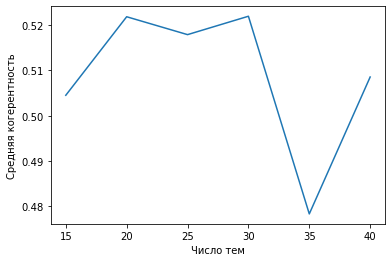

In [15]:
coherences = []

for x in tqdm(params['num_topics']):
    lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=x, passes=3, random_state=42)
    coherences.append(CoherenceModel(model=lda, texts=clean_texts.text, dictionary=dictionary, coherence='c_v').get_coherence())

best_num_topics = params['num_topics'][np.argmax(coherences)]

plt.plot(params['num_topics'], coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

100%|██████████| 6/6 [04:49<00:00, 48.28s/it]


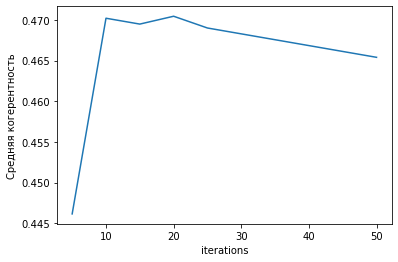

In [17]:
coherences = []

for x in tqdm(params['iterations']):
    lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=20, iterations=x, random_state=42)
    coherences.append(CoherenceModel(model=lda, texts=clean_texts.text, dictionary=dictionary, coherence='c_v').get_coherence())

best_iterations = params['iterations'][np.argmax(coherences)]
plt.plot(params['iterations'], coherences)
plt.xlabel("iterations")
plt.ylabel("Средняя когерентность")
plt.show()

100%|██████████| 5/5 [40:14<00:00, 482.85s/it]


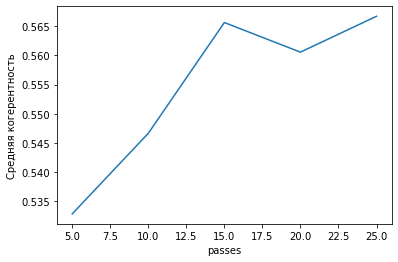

In [17]:
coherences = []

for x in tqdm(params['passes']):
    lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=20, iterations = 20, passes=x, random_state=42)
    coherences.append(CoherenceModel(model=lda, texts=clean_texts.text, dictionary=dictionary, coherence='c_v').get_coherence())

best_passes = params['passes'][np.argmax(coherences)]

plt.plot(params['passes'], coherences)
plt.xlabel("passes")
plt.ylabel("Средняя когерентность")
plt.show()

100%|██████████| 4/4 [26:11<00:00, 392.92s/it]


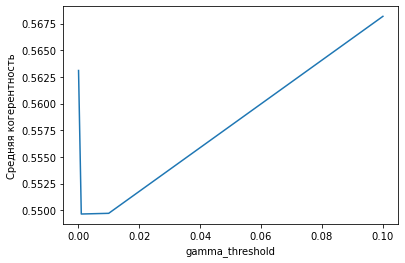

In [19]:
coherences = []

# params['gamma_threshold'] =  [0.01,0.02, 0.03]
i = 0
for x in tqdm(params['gamma_threshold']):
    i+=1
    lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=20, iterations = 20, passes=15, gamma_threshold = x, random_state=42)
    coherences.append(CoherenceModel(model=lda, texts=clean_texts.text, dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(params['gamma_threshold'], coherences)
plt.xlabel("gamma_threshold")
plt.ylabel("Средняя когерентность")
plt.show()

In [23]:
%%time

lda1 = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=20, iterations = 20, passes=15, gamma_threshold = 0.1, random_state=42)
lda2 = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=15, passes=10, iterations=20, gamma_threshold = 0.004, random_state=42)

CPU times: user 7min 3s, sys: 37.9 s, total: 7min 41s
Wall time: 9min 4s


In [17]:
lda1 = LdaMulticore.load('LDA/lda1_bigrm.model')
lda1.log_perplexity(corpus)
# lda2.save('LDA/lda2_bigrm.model')

-10.044892070516417

In [18]:
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda1, texts=clean_texts.text, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
coherence_lda

0.5407546865907785

In [19]:
# BEST MODEL
lda2 = LdaMulticore.load('LDA/lda2_bigrm.model')
lda2.log_perplexity(corpus)

-9.628616554001432

In [20]:
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda2, texts=clean_texts.text, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
coherence_lda

0.5681495549927998

In [21]:
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda, texts=clean_texts.text, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
coherence_lda

0.5666698484422138

In [21]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
/home/mchelushkin/anaconda3/lib/python3.8/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/mchelushkin/anaconda3/lib/python3.8/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


CPU times: user 18.7 s, sys: 685 ms, total: 19.3 s
Wall time: 24 s
